# Week 02

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/var/folders/hl/6492kk1939x_mv_8fr9qfz_40000gn/T/ipykernel_39471/2151744951.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Check and handle empty data

In stock analysis tasks, using fitted values to fill in empty data is harmful to accurate prediction results, so empty data entries should be deleted.

## Data merging and time alignment
The time accuracy of the 5-year historical data we obtained is uneven. You need to merge all historical data together so that all data have the same time accuracy.
> Difficulty: How to deal with Volumes of different time scales?

## Auxiliary data broadcast
In addition to historical stock prices, other data such as cash flow and assets and liabilities need to be integrated into your features. But the data we obtain are quarterly or even annual. Because these data are disclosed in financial reports released every quarter, and are manually entered as data by some third-party projects (such as yfinance)

As data for auxiliary forecasting, even if there are only 8 financial reports in a two-year time scale, the financial report data still need to be broadcast to each quarter's time period. The data for the past 3-5 years may need to be obtained by querying the company's financial reports, and Prepare to simplify data dimensions and explore their correlations through subsequent feature engineering.

## Historical volatility
According to the logarithmic price change method formula:
$$
\begin{gathered}
X_i=\ln \frac{P_{i+1}}{P_i}=\ln P_{i+1}-\ln P_i \\
\bar{X}=\frac{1}{N} \sum X_i \\
\sigma=\sqrt{\frac{\sum\left(X_i-\bar{X}\right)^2}{N-1}}
\end{gathered}
$$

Calculate all historical volatility with 1d accuracy and 2 years, and draw it as a plot together with the box chart of historical price data. 

Find whether NVDA (i.e. NVIDIA) has corresponding news/event support when volatility occurs abnormally.


In [16]:
# Load the data again correctly
file_path = '../../data/row/NVDA_5_years_daily_data.csv'
data = pd.read_csv(file_path, index_col='date', parse_dates=True)

# Ensure the data is sorted by date for accurate calculations
data.sort_index(inplace=True)

def get_last_n_years_data(n):
    # Filter for the last n years
    now = pd.Timestamp.now()
    start_date = now - pd.DateOffset(years=n)
    return data.loc[start_date:]['5. adjusted close']

data_2_years = get_last_n_years_data(n=2)
data_3_years = get_last_n_years_data(n=3)

# Calculate daily logarithmic returns
log_returns = np.log(data_3_years / data_3_years.shift(1))

# Calculate the historical volatility
volatility = log_returns.rolling(window=252).std() * np.sqrt(252)

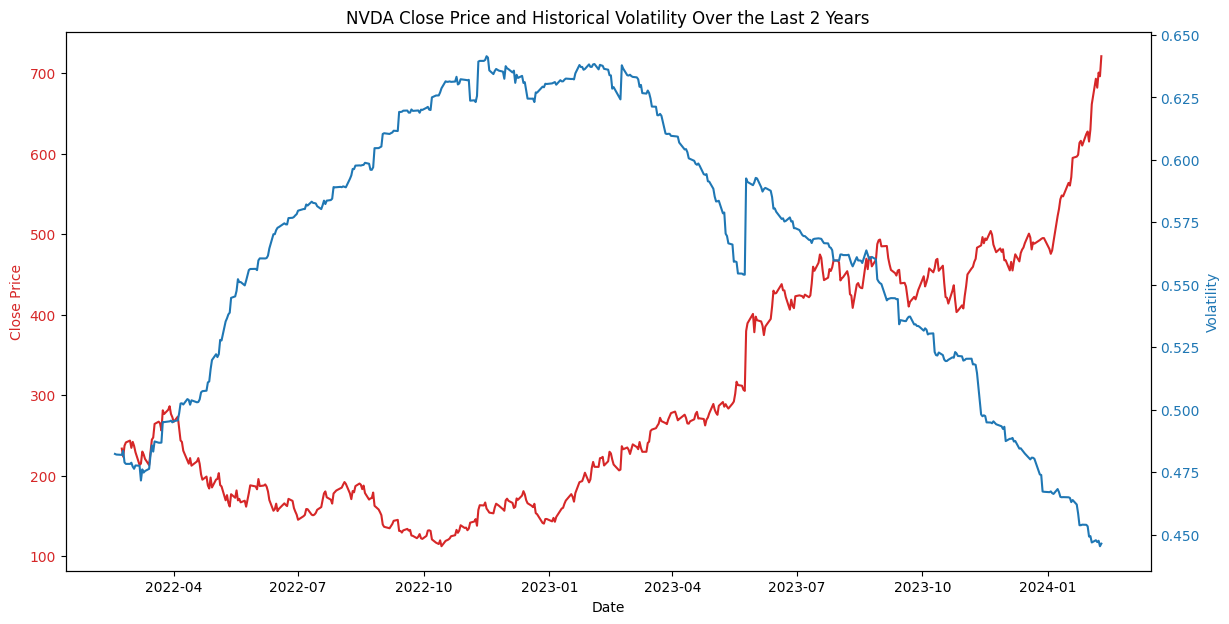

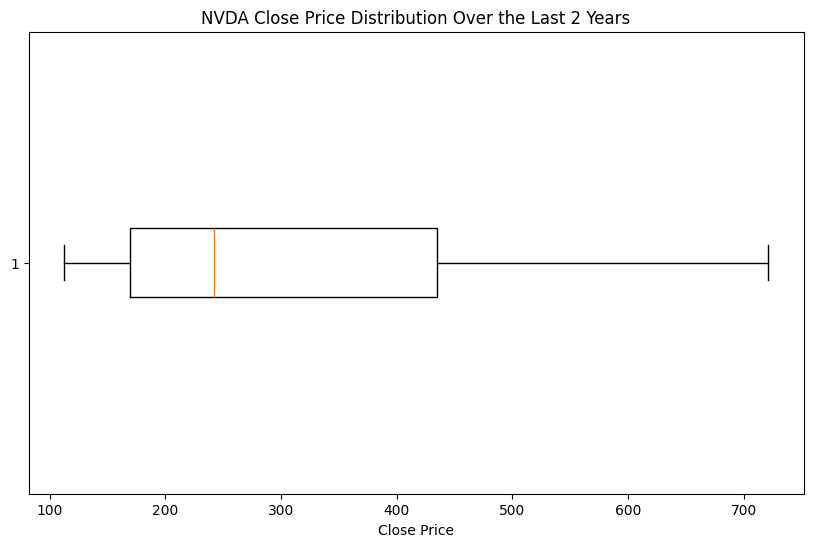

In [17]:
# Plotting
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot close prices
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color=color)
ax1.plot(data_2_years.index, data_2_years, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a twin axis for volatility
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Volatility', color=color)
ax2.plot(volatility.index, volatility, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('NVDA Close Price and Historical Volatility Over the Last 2 Years')
plt.show()

# Boxplot for the close prices
plt.figure(figsize=(10, 6))
plt.boxplot(data_2_years.dropna(), vert=False)
plt.title('NVDA Close Price Distribution Over the Last 2 Years')
plt.xlabel('Close Price')
plt.show()

Faced with data that is unevenly distributed over time (the longer the data, the smaller the amount of data), how should we deal with it when performing feature engineering and window sampling?
What is the relationship between data proportion?